In [95]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import WordPunctTokenizer

import re

from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve

from sklearn.tree import export_graphviz
from IPython.display import Image  
from pydotplus import graph_from_dot_data
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

from sklearn.metrics import plot_confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data = pd.read_csv('dataset.csv', encoding='latin-1')
data.head()

,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


In [3]:
data.Sentiment.value_counts(normalize=True)

1    0.5
0    0.5
Name: Sentiment, dtype: float64

In [4]:
data.isna().sum()

SentimentText    0
Sentiment        0
dtype: int64

In [5]:
for i in list(range(0,5)):
    print(data.SentimentText[i], '\n')

first think another Disney movie, might good, it's kids movie. watch it, can't help enjoy it. ages love movie. first saw movie 10 8 years later still love it! Danny Glover superb could play part better. Christopher Lloyd hilarious perfect part. Tony Danza believable Mel Clark. can't help, enjoy movie! give 10/10! 

Put aside Dr. House repeat missed, Desperate Housewives (new) watch one. don't know exactly plagued movie. never thought I'd say this, want 15 minutes fame back.<br /><br />Script, Direction, can't say. recognized stable actors (the usual suspects), thought Herbert Marshall class addition sat good cheesy flick. Boy, wrong. Dullsville.<br /><br />My favorite parts: "office girl" makes 029 keypunch puts cards 087 sorter. LOL @ "the computer". I'd like someone identify next device - 477 ? It's even dinosaur's time.<br /><br />And dinosaurs don't much time waste. 

big fan Stephen King's work, film made even greater fan King. Pet Sematary Creed family. moved new house, seem happ

In [6]:


pat_1 = r"(?:\@|https?\://)\S+"
pat_2 = r'#\w+ ?'
combined_pat = r'|'.join((pat_1, pat_2))
www_pat = r'www.[^ ]+'
html_tag = r'<[^>]+>'
negations_ = {"isn't":"is not", "can't":"can not","couldn't":"could not", "hasn't":"has not",
                "hadn't":"had not","won't":"will not",
                "wouldn't":"would not","aren't":"are not",
                "haven't":"have not", "doesn't":"does not","didn't":"did not",
                 "don't":"do not","shouldn't":"should not","wasn't":"was not", "weren't":"were not",
                "mightn't":"might not",
                "mustn't":"must not"}
negation_pattern = re.compile(r'\b(' + '|'.join(negations_.keys()) + r')\b')

In [7]:

tokenizer = WordPunctTokenizer()

In [8]:
def data_cleaner(text):
    try:
        stripped = re.sub(combined_pat, '', text)
        stripped = re.sub(www_pat, '', stripped)
        cleantags = re.sub(html_tag, '', stripped)
        lower_case = cleantags.lower()
        neg_handled = negation_pattern.sub(lambda x: negations_[x.group()], lower_case)
        letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
        tokens = tokenizer.tokenize(letters_only)
        return (" ".join(tokens)).strip()
    except:
        return 'NC'

In [9]:

b = data_cleaner(data.iloc[1].SentimentText)
b

'put aside dr house repeat missed desperate housewives new watch one do not know exactly plagued movie never thought i d say this want minutes fame back script direction can not say recognized stable actors the usual suspects thought herbert marshall class addition sat good cheesy flick boy wrong dullsville my favorite parts office girl makes keypunch puts cards sorter lol the computer i d like someone identify next device it s even dinosaur s time and dinosaurs do not much time waste'

In [10]:
# for i in list(range(0, len(data))):
    
#     data.iloc[1].SentimentText = data_cleaner(data.iloc[1].SentimentText)

In [11]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

def post_process(data, n=1000000):
    data = data.head(n)
    data['SentimentText'] = data['SentimentText'].progress_map(data_cleaner)  
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data

In [12]:
df = post_process(data)

progress-bar: 100%|██████████| 25000/25000 [00:08<00:00, 3050.63it/s]


In [13]:
df.head()

,SentimentText,Sentiment
0,first think another disney movie might good it...,1
1,put aside dr house repeat missed desperate hou...,0
2,big fan stephen king s work film made even gre...,1
3,watched horrid thing tv needless say one movie...,0
4,truly enjoyed film acting terrific plot jeff c...,1


Now our data is clean. Before proceeding to developing our baseline model we will do some visualization of our textual data.

First let's create a wordcloud for negative comments on our data.

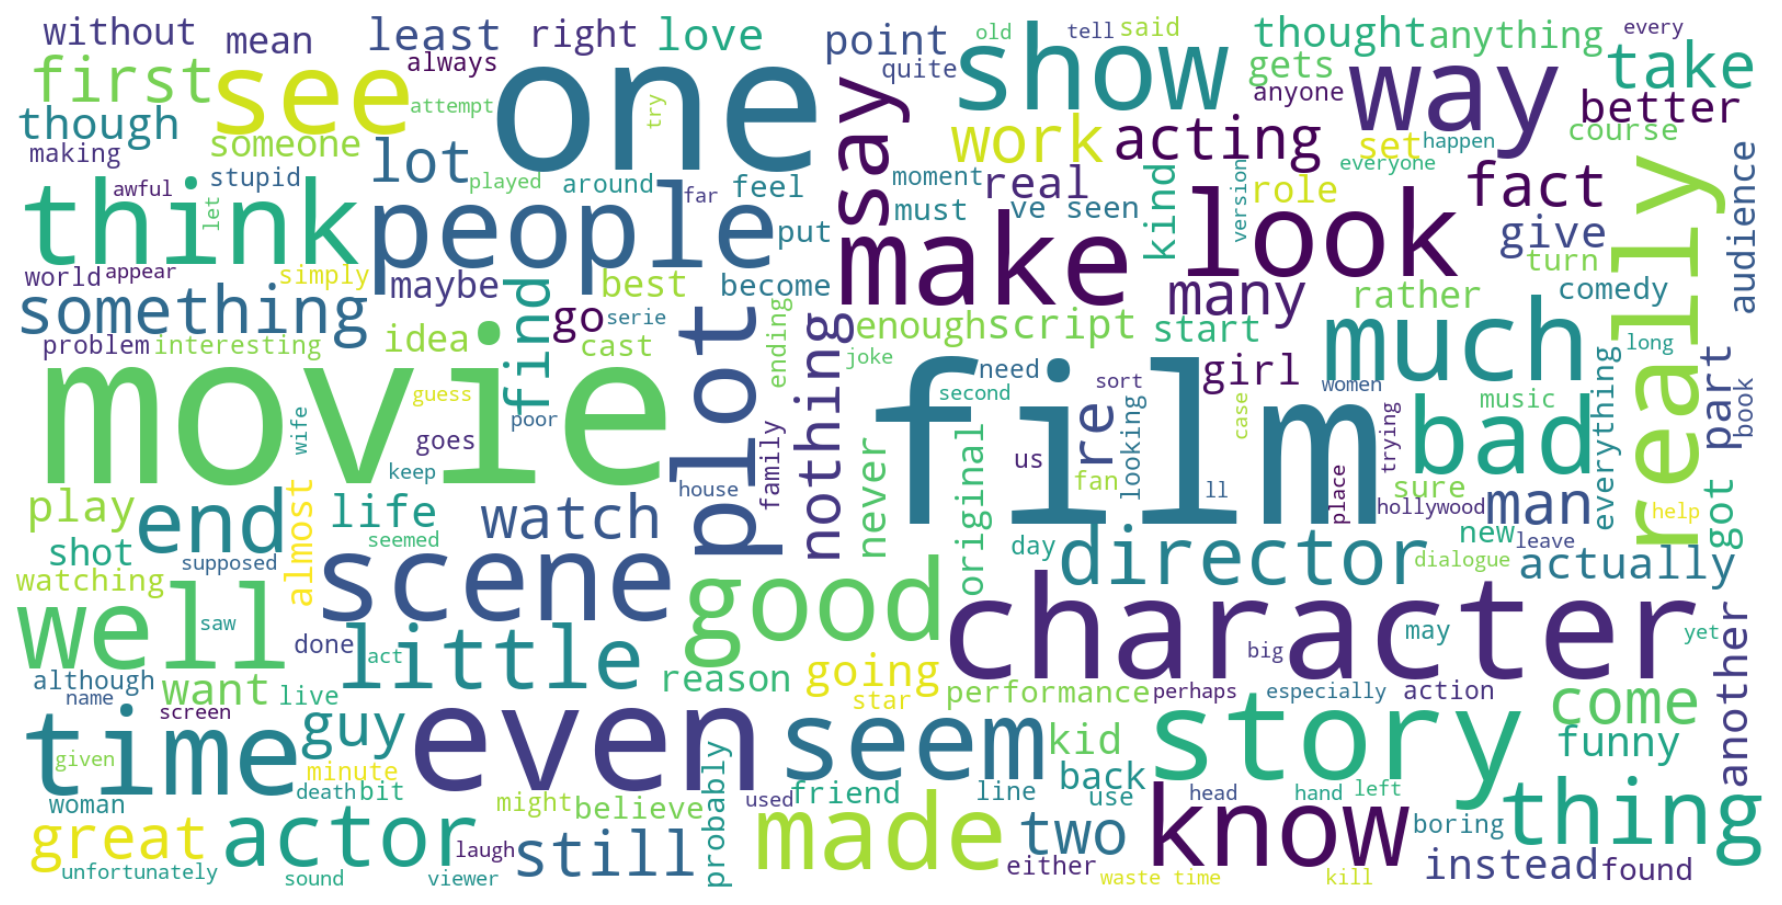

In [14]:
#Getting negative comments from the text
neg_df = df[df.Sentiment == 0]
neg_comments = []
for t in neg_df.SentimentText:
    neg_comments.append(t)
#Concetanating the text from all the rows of negative comments.
neg = pd.Series(neg_comments).str.cat(sep = ' ')

wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color='white').generate(neg)
fig = plt.figure(figsize=(14,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Another wordcloud for positive comments.

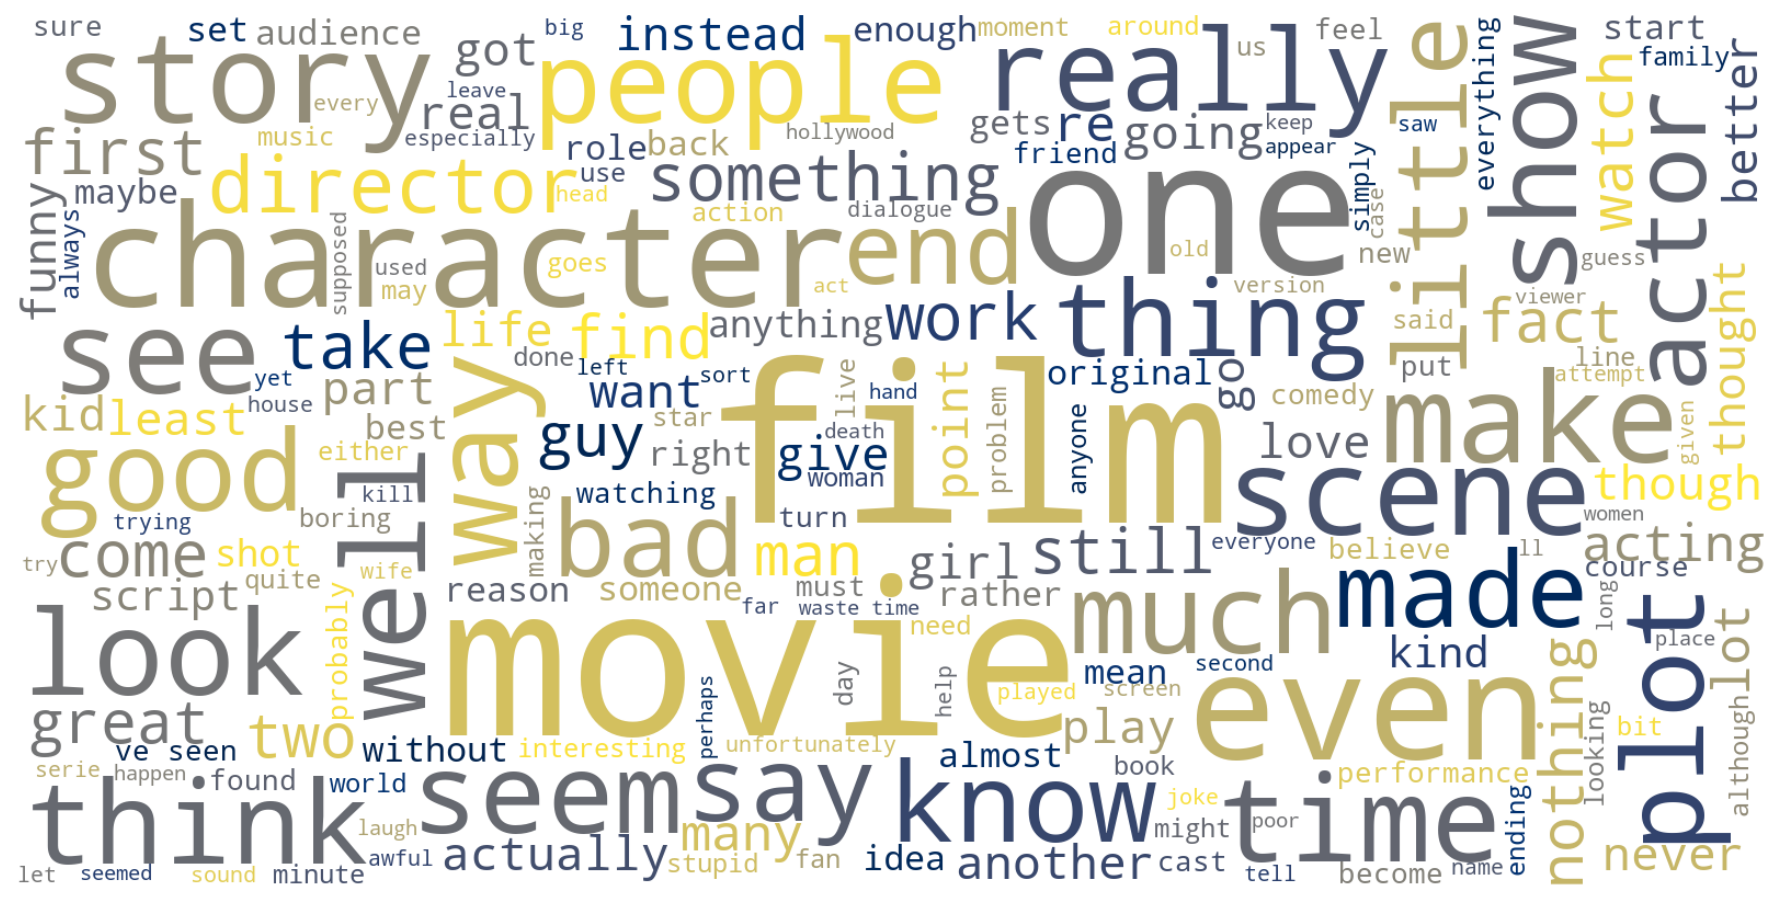

In [15]:
pos_df = df[df.Sentiment == 1]
pos_comments = []
for t in pos_df.SentimentText:
    pos_comments.append(t)
#Concetanating the text from all the rows of negative comments.
pos = pd.Series(pos_comments).str.cat(sep = ' ')

wordcloud = WordCloud(width=1600, height=800, max_font_size=200,colormap='cividis' ,background_color='white').generate(neg)
fig = plt.figure(figsize=(14,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Before the baseline model let's split our data into train and test sets.

In [16]:
seed = 142
target = df['Sentiment']
vec = TfidfVectorizer(ngram_range=(1,1))
text_vectorized = vec.fit_transform(df['SentimentText'])
X_train_vec, X_test_vec, y_train, y_test = train_test_split(text_vectorized, target, test_size=0.20, random_state=seed)

In [17]:
#Vectorizing and tokenizing 

In [18]:
# vec = TfidfVectorizer(ngram_range=(1,1))
# X_train_vec = vec.fit_transform(X_train)

In [19]:
X_train_vec.shape

(20000, 74093)

## Baseline Model

In [20]:
dt_cl = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=500)
cv = KFold(n_splits=5,shuffle=True,random_state=seed)
dt_score_f1 = round(np.mean(cross_val_score(dt_cl,X_train_vec, y_train, cv = cv,  scoring='f1')),4)
dt_score_roc_auc = round(np.mean(cross_val_score(dt_cl,X_train_vec, y_train, cv = cv,  scoring='roc_auc')),4)

In [21]:
print(dt_score_f1, dt_score_roc_auc)

0.7343 0.7158


## Model Selection

#### Decision Tree 

In [22]:
dcs_tree_clf = DecisionTreeClassifier()

dt_param_grid = {
    'criterion': ['entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [10, 500, 1000]
}
#insantiate the GridSearchCV
dt_grid_search = GridSearchCV(dcs_tree_clf, dt_param_grid, cv=cv, return_train_score=True)

dt_grid_search.fit(X_train_vec, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=142, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             para

In [23]:
dt_grid_search.best_params_
best_dt = dt_grid_search.best_estimator_
best_dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=1000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [24]:
dt_predict_proba = cross_val_predict(best_dt, X_train_vec, y_train ,method='predict_proba', cv=cv)[:,1]
dt_predict = cross_val_predict(best_dt, X_train_vec, y_train ,method='predict', cv=cv)

In [25]:
roc_auc_dt = roc_auc_score(y_train, dt_predict_proba)
print(roc_auc_dt)
f1_dt = f1_score(y_train, dt_predict)
print(f1_dt)

0.8105775092401478
0.7434455047714715


In [26]:
fpr_dt, tpr_dt, thr_dt = roc_curve(y_train, dt_predict_proba)

#### Logistic Regression 

In [27]:
log_cl = LogisticRegression(class_weight='balanced')
cv = KFold(n_splits=5,shuffle=True,random_state=seed)
log_score_f1 = round(np.mean(cross_val_score(log_cl,X_train_vec, y_train, cv = cv,  scoring='f1')),4)
log_score_roc_auc = round(np.mean(cross_val_score(log_cl,X_train_vec, y_train, cv = cv,  scoring='roc_auc')),4)

In [28]:
log_predict = cross_val_predict(log_cl, X_train_vec, y_train ,method='predict', cv=cv)
log_predict_proba = cross_val_predict(log_cl, X_train_vec, y_train ,method='predict_proba', cv=cv)[:,1]

In [29]:
fpr_log, tpr_log, thr_log = roc_curve(y_train, log_predict_proba)

In [30]:
print(log_score_f1, log_score_roc_auc)

0.8888 0.9546


#### Linear SVC

In [31]:
svc_cl = LinearSVC()
svc_param_grid = {'C':np.arange(0.01,100,10)}
linearSVC = GridSearchCV(svc_cl,svc_param_grid,cv=5,return_train_score=True)
linearSVC.fit(X_train_vec,y_train)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

bestlinearSVC = linearSVC.best_estimator_
bestlinearSVC.fit(X_train_vec,y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:965: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'C': 10.01}


LinearSVC(C=10.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [32]:
svc_score_f1 = round(np.mean(cross_val_score(bestlinearSVC,X_train_vec, y_train, cv = cv,  scoring='f1')),4)
svc_score_roc_auc = round(np.mean(cross_val_score(bestlinearSVC,X_train_vec, y_train, cv = cv,  scoring='roc_auc')),4)

In [33]:
svc_predict = cross_val_predict(bestlinearSVC, X_train_vec, y_train ,method='predict', cv=cv)

In [34]:
fpr_svc, tpr_svc, thr_svc = roc_curve(y_train, svc_predict)

In [35]:
print(svc_score_f1, svc_score_roc_auc)

0.8776 0.9477


#### Ridge Classifier

In [36]:
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
ridge_cl = RidgeClassifier()
ridge_grid = GridSearchCV(estimator=ridge_cl, param_grid=dict(alpha=alphas), cv=cv, return_train_score=True)
ridge_grid.fit(X_train_vec,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=142, shuffle=True),
             error_score=nan,
             estimator=RidgeClassifier(alpha=1.0, class_weight=None,
                                       copy_X=True, fit_intercept=True,
                                       max_iter=None, normalize=False,
                                       random_state=None, solver='auto',
                                       tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [37]:
ridge_grid.best_params_
best_ridge = ridge_grid.best_estimator_
best_ridge

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [38]:
ridge_score_f1 = round(np.mean(cross_val_score(best_ridge,X_train_vec, y_train, cv = cv,  scoring='f1')),4)
ridge_score_roc_auc = round(np.mean(cross_val_score(best_ridge,X_train_vec, y_train, cv = cv,  scoring='roc_auc')),4)

In [39]:
ridge_predict = cross_val_predict(best_ridge, X_train_vec, y_train ,method='predict', cv=cv)

In [40]:
fpr_ridge, tpr_ridge, thr_ridge = roc_curve(y_train, ridge_predict)

In [41]:
print(ridge_score_f1, ridge_score_roc_auc)

0.891 0.957


#### Multinomial Naive Bayes

In [42]:
alphas = np.array([1,0.1,0.01,0.001,0.0001])
mn_naive_cl = MultinomialNB()
mn_naive_grid = GridSearchCV(estimator=mn_naive_cl, param_grid=dict(alpha=alphas), cv=cv, return_train_score=True)
mn_naive_grid.fit(X_train_vec,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=142, shuffle=True),
             error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [43]:
mn_naive_grid.best_params_
best_mn_naive = mn_naive_grid.best_estimator_
best_mn_naive

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [44]:
mn_naive_score_f1 = round(np.mean(cross_val_score(best_mn_naive,X_train_vec, y_train, cv = cv,  scoring='f1')),4)
mn_naive_score_roc_auc = round(np.mean(cross_val_score(best_mn_naive,X_train_vec, y_train, cv = cv,  scoring='roc_auc')),4)

In [45]:
mnb_predict = cross_val_predict(best_mn_naive, X_train_vec, y_train ,method='predict', cv=cv)
mnb_predict_proba = cross_val_predict(best_mn_naive, X_train_vec, y_train ,method='predict_proba', cv=cv)[:,1]

In [46]:
fpr_mnb, tpr_mnb, thr_mnb = roc_curve(y_train, mnb_predict_proba)

In [47]:
print(mn_naive_score_f1, mn_naive_score_roc_auc)

0.8575 0.9382


#### Bernouilli Naive Bayes

In [48]:
alphas = np.array([1,0.1,0.01,0.001,0.0001])
b_naive_param_grid = {'alpha' : alphas, 'fit_prior': [True,False]}
b_naive_cl = BernoulliNB()
b_naive_grid = GridSearchCV(estimator=b_naive_cl, param_grid=b_naive_param_grid, cv=cv, return_train_score=True)
b_naive_grid.fit(X_train_vec,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=142, shuffle=True),
             error_score=nan,
             estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                                   fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04]),
                         'fit_prior': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [49]:
b_naive_grid.best_params_
best_b_naive = b_naive_grid.best_estimator_
best_b_naive

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=False)

In [50]:
b_naive_score_f1 = round(np.mean(cross_val_score(best_b_naive,X_train_vec, y_train, cv = cv,  scoring='f1')),4)
b_naive_score_roc_auc = round(np.mean(cross_val_score(best_b_naive,X_train_vec, y_train, cv = cv,  scoring='roc_auc')),4)

In [51]:
bnb_predict = cross_val_predict(best_b_naive, X_train_vec, y_train ,method='predict', cv=cv)
bnb_predict_proba = cross_val_predict(best_b_naive, X_train_vec, y_train ,method='predict_proba', cv=cv)[:,1]

In [52]:
fpr_bnb, tpr_bnb, thr_bnb = roc_curve(y_train, bnb_predict_proba)

In [53]:
print(b_naive_score_f1, b_naive_score_roc_auc)

0.8438 0.9263


### Ensemble Methods

#### Ada Boost Classifier

In [54]:
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]
             }

ABC = AdaBoostClassifier(base_estimator = best_dt)

# run grid search
ada_grid = GridSearchCV(estimator=ABC, param_grid=ada_param_grid, cv=cv, return_train_score=True)
ada_grid.fit(X_train_vec,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=142, shuffle=True),
             error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='entropy',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                     

In [55]:
ada_grid.best_params_
best_ada = ada_grid.best_estimator_
best_ada

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=1000,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                 

In [56]:
ada_score_f1 = round(np.mean(cross_val_score(best_ada,X_train_vec, y_train, cv = cv,  scoring='f1')),4)
ada_score_roc_auc = round(np.mean(cross_val_score(best_ada,X_train_vec, y_train, cv = cv,  scoring='roc_auc')),4)

In [57]:
ada_predict = cross_val_predict(best_ada, X_train_vec, y_train ,method='predict', cv=cv)
ada_predict_proba = cross_val_predict(best_ada, X_train_vec, y_train ,method='predict_proba', cv=cv)[:,1]

In [58]:
fpr_ada, tpr_ada, thr_ada = roc_curve(y_train, ada_predict_proba)

In [59]:
print(ada_score_f1, ada_score_roc_auc)

0.768 0.8407


#### Voting Classifier

In [60]:
estimators = [('lr', log_cl), ('dt', best_dt), ('mnb', best_mn_naive), ('abc', best_ada)]
vot_param_grid = {"voting" :   ["hard", "soft"]}
vot_cl = VotingClassifier(estimators=estimators)
vot_grid = GridSearchCV(estimator=vot_cl, param_grid=vot_param_grid, cv=cv, return_train_score=True)
vot_grid.fit(X_train_vec,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=142, shuffle=True),
             error_score=nan,
             estimator=VotingClassifier(estimators=[('lr',
                                                     LogisticRegression(C=1.0,
                                                                        class_weight='balanced',
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='auto',
                                                                        n_jobs=None,
                                                 

In [61]:
vot_grid.best_params_
best_vot = vot_grid.best_estimator_
best_vot

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('dt',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='...
                                        

In [62]:
vot_score_f1 = round(np.mean(cross_val_score(best_vot,X_train_vec, y_train, cv = cv,  scoring='f1')),4)
vot_score_roc_auc = round(np.mean(cross_val_score(best_vot,X_train_vec, y_train, cv = cv,  scoring='roc_auc')),4)

In [63]:
vot_predict = cross_val_predict(best_vot, X_train_vec, y_train ,method='predict', cv=cv)
vot_predict_proba = cross_val_predict(best_vot, X_train_vec, y_train ,method='predict_proba', cv=cv)[:,1]

In [64]:
fpr_vot, tpr_vot, thr_vot = roc_curve(y_train, vot_predict_proba)

In [65]:
fprs_tprs = [{'decision tree': [fpr_dt, tpr_dt]}, {'logistic regression': [fpr_log, tpr_log]}, {'linear svc': [fpr_svc,tpr_svc]},
       {'ridge': [fpr_ridge, tpr_ridge]}, {'multinomial naive bayes': [fpr_mnb, tpr_mnb]}, {'bernouilli naive bayes':[fpr_bnb,tpr_bnb]},
       {'ada boost classifier': [fpr_ada, tpr_ada]}, {'voting classifier': [fpr_vot, tpr_vot]}]
roc_auc_scores = [{'decision tree': dt_score_roc_auc}, {'logistic regression': log_score_roc_auc}, {'linear svc': [fpr_svc,tpr_svc]},
       {'ridge': [fpr_ridge, tpr_ridge]}, {'multinomial naive bayes': [fpr_mnb, tpr_mnb]}, {'bernouilli naive bayes':[fpr_bnb,tpr_bnb]},
       {'ada boost classifier': [fpr_ada, tpr_ada]}, {'voting classifier': [fpr_vot, tpr_vot]}]

In [66]:
def plot_roc_curve(list_fpr_tpr, label=None):
    colors =['b','g','r','c','m','y','k','w']
    fig = plt.figure(figsize=(12,8))
    for i in list(range(0, len(fprs_tprs))):
        label = list(fprs_tprs[i].keys())[0]
        plt.plot(list(fprs_tprs[i].values())[0][0],list(fprs_tprs[i].values())[0][1],linewidth= 2,color=colors[i], label=label)
    plt.plot([0,1], [0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')   
    plt.title('Roc Curve Comparison for Different Classifiers')
    plt.legend(loc=4)

    

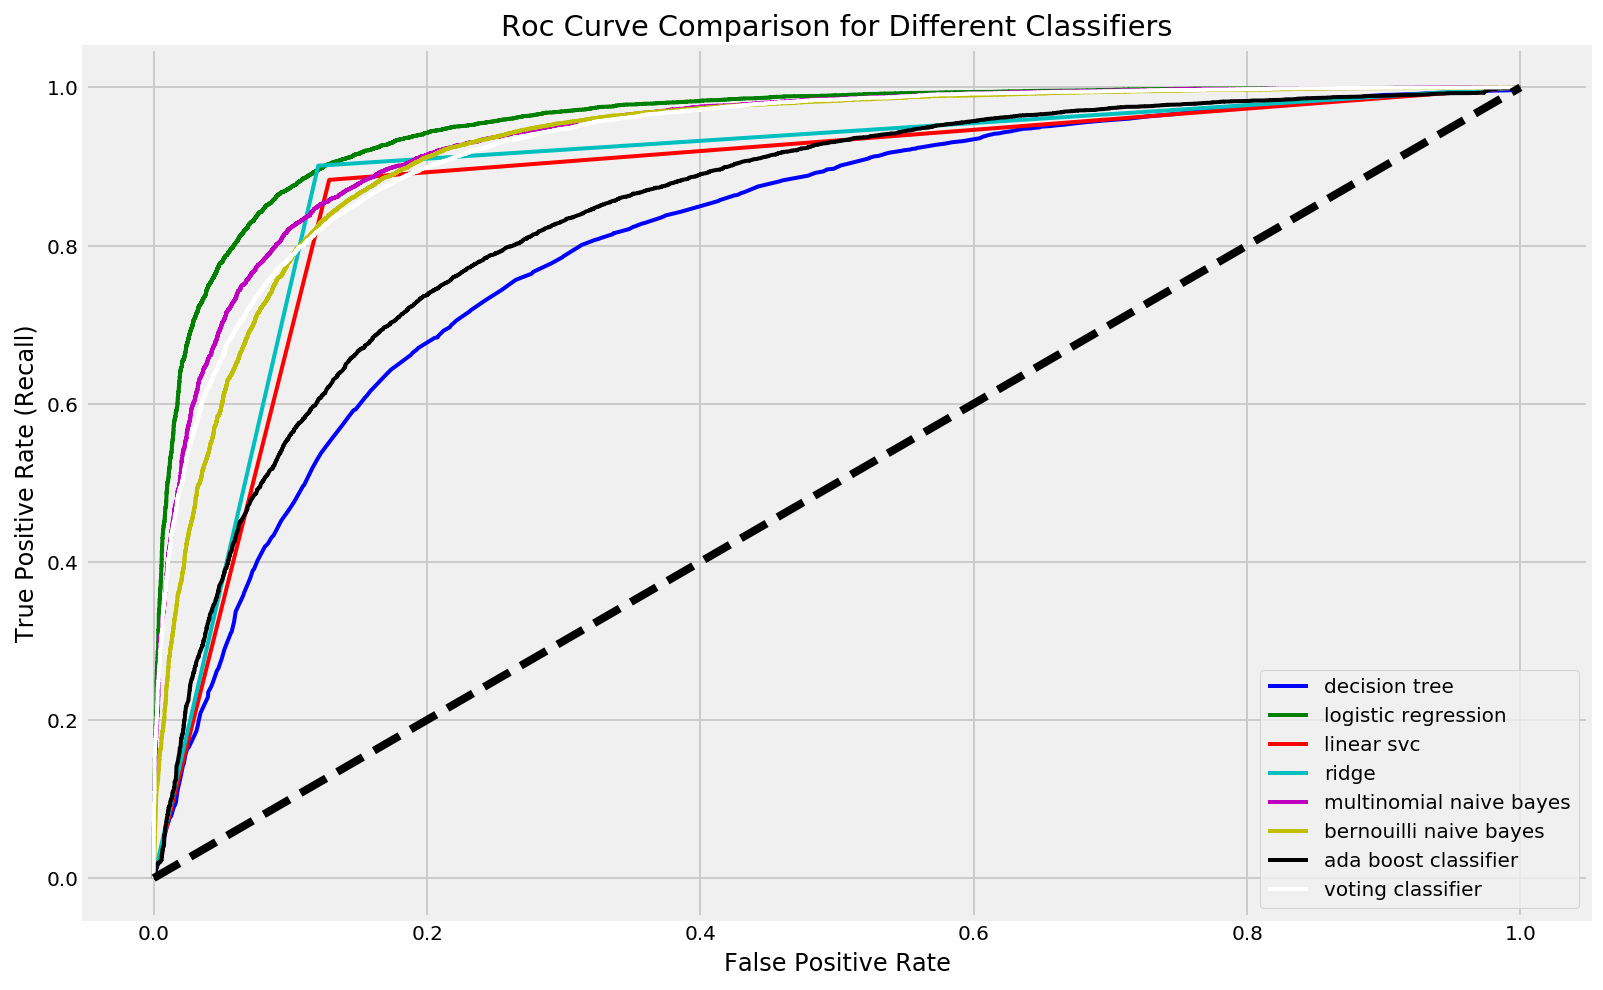

In [67]:
plot_roc_curve(fprs_tprs)

Looking at the graph above we can confidently say that Ridge Classifier Model performed best with our training data set. We'll go ahead and use test this model with our test data.

## TESTING MODEL

In [75]:
test_f1 = round(np.mean(cross_val_score(best_ridge,X_test_vec, y_test, cv = cv,  scoring='f1')),4)
test_roc_auc = round(np.mean(cross_val_score(best_ridge,X_test_vec, y_test, cv = cv,  scoring='roc_auc')),4)

In [76]:
test_predict = cross_val_predict(best_ridge, X_test_vec, y_test ,method='predict', cv=cv)

In [78]:
print(test_f1, test_roc_auc)

0.8691 0.9364


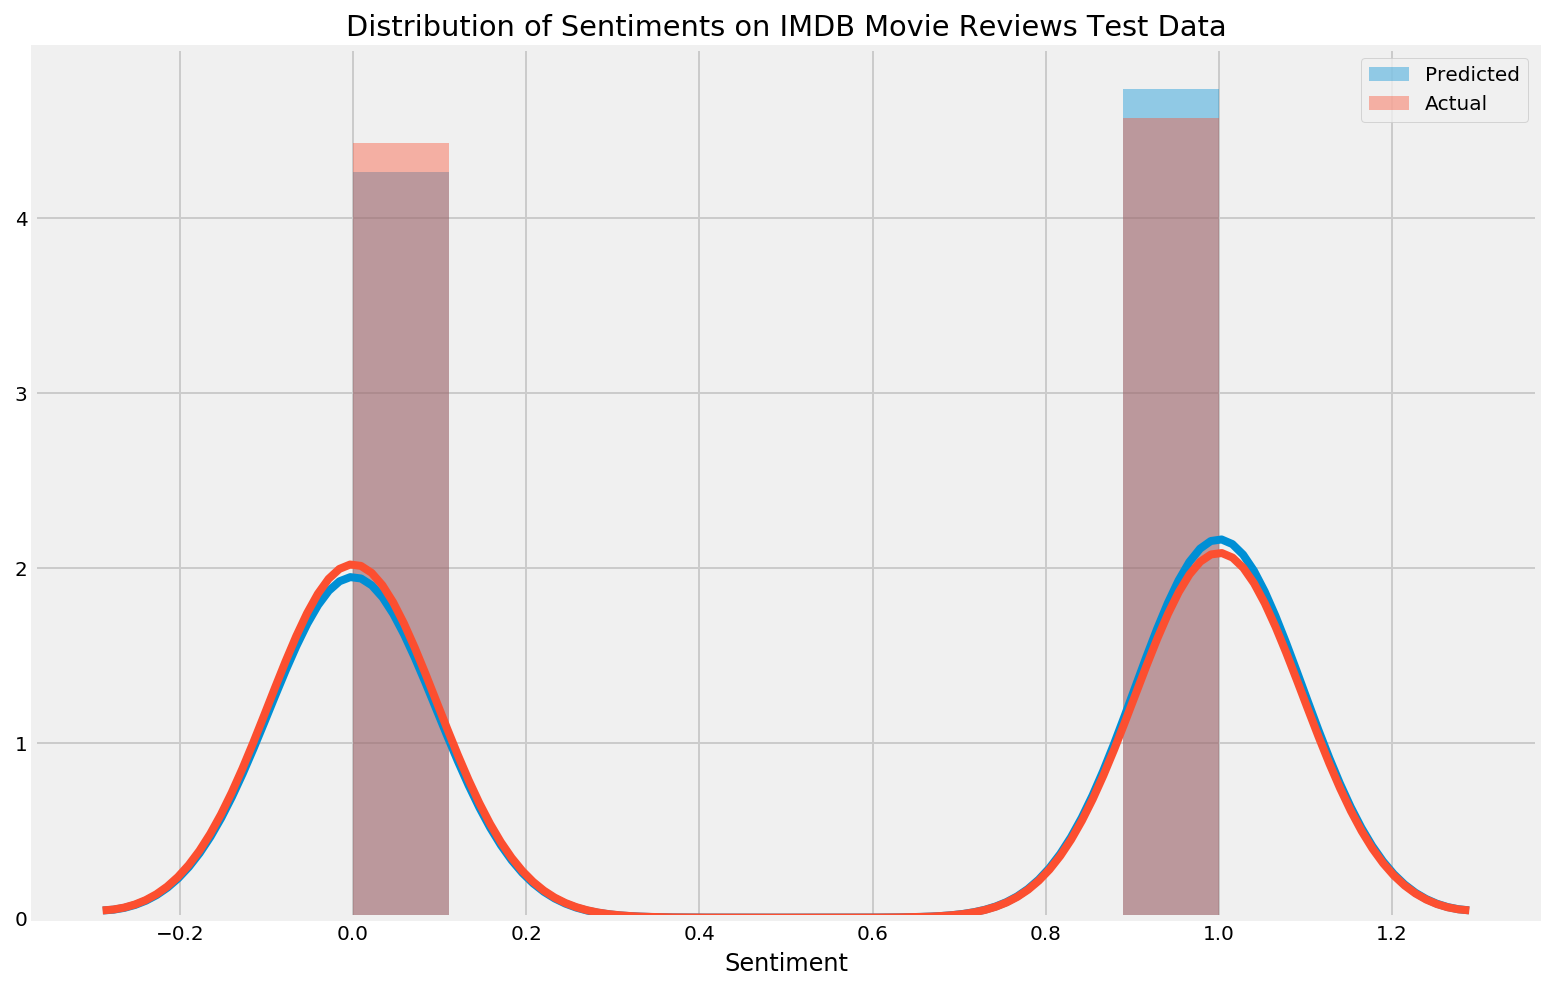

In [100]:
fig = plt.figure(figsize=(12,8))
sns.distplot(test_predict, label='Predicted')
sns.distplot(y_test, label='Actual')
plt.title('Distribution of Sentiments on IMDB Movie Reviews Test Data')
plt.legend()
plt.show()

Our model predicts slightly more optimistic.

[[0.87886179 0.12113821]
 [0.1015748  0.8984252 ]]


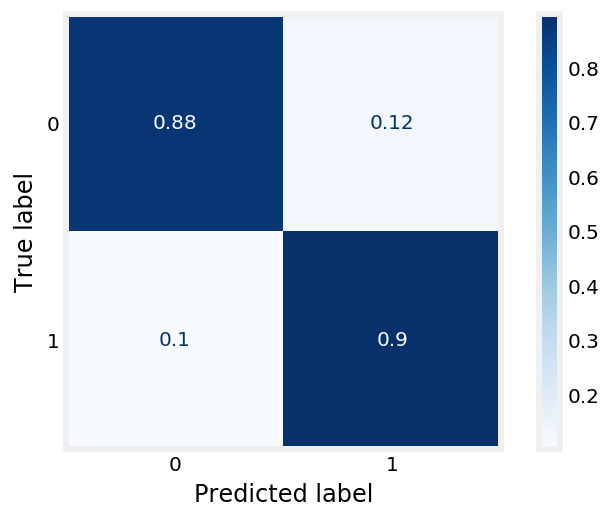

In [94]:
print(cm_plot.confusion_matrix)
cm_plot = plot_confusion_matrix(best_ridge,X_test_vec, y_test, cmap=plt.cm.Blues, normalize='true')
# plt.axis('off')
plt.grid(b=None)
plt.show()

### For Improvement

As an example of model's practicality choose a random movie and collect comments about tham. Do the sentiment analyses on those comments via final version of our model. 